# Predict how many visitors a restaurant will receive

## 1. Introduction

- 목표는 미래의 식당 고객수를 예측하는 것이며, Time-series 분석 문제이다.
- 일본 2개 웹사이트(hpg & AirREGI)에서 나온 8개의 연관 파일로 이뤄진 일식당의 데이터

__파일 설명__<br>
* air_visit_data.csv: air restaurants의 과거 방문 data. main training data set이다.

* air_reserve.csv / hpg_reserve.csv: air & hpg 레스토랑 예약 시스템

* air_store_info.csv / hpg_store_info.csv: air & hpg 레스토랑 세부 정보

* store_id_relation.csv: air & hpg id

* date_info.csv: 일본 공휴일 정보

* sample_submission.csv: test set으로 사용. ’id’는 air id와 방문 날짜를 결합하여 생성

## 2. Preparations

### 2.1 Load libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from datetime import datetime
import datetime
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

### 2.2 Load data

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/restaurant_visitor_forecasting/data/'

air_visits = pd.read_csv(data_dir + "air_visit_data.csv")
air_reserve = pd.read_csv(data_dir + "air_reserve.csv")
hpg_reserve = pd.read_csv(data_dir + "hpg_reserve.csv")
air_store  = pd.read_csv(data_dir + "air_store_info.csv")
hpg_store = pd.read_csv(data_dir + "hpg_store_info.csv")
holidays = pd.read_csv(data_dir + "date_info.csv")
store_ids  = pd.read_csv(data_dir + "store_id_relation.csv")
submission = pd.read_csv(data_dir + "sample_submission.csv")

## 3. Overview: File Structure and content

### 3.1 Air visits

air 레스토랑에 대한 과거 방문 데이터
- air_store_id
- visit_date - 날짜
- visitors - 해당 날짜의 레스토랑 방문자 수

In [3]:
air_visits.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
air_visits.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


### 3.2 Air Reserve

air에서 이루어진 예약
- air_store_id - 항공 시스템에서 레스토랑의 id
- visit_datetime - 예약 시간(방문 시간)
- reserve_datetime - 예약한 시간
- reserve_visitors - 해당 예약의 방문자 수

In [5]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [6]:
air_reserve.describe()

,reserve_visitors
count,92378.000000
mean,4.481749
std,4.919669
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


### 3.3 Hpg reserve

hpg 시스템에서 이루어진 예약
- hpg_store_id - hpg 시스템의 레스토랑 ID
- visit_datetime - 예약 시간
- reserve_datetime - 예약한 시간
- reserve_visitors - 해당 예약의 방문자 수

In [7]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [8]:
hpg_reserve.describe()

,reserve_visitors
count,2.000320e+06
mean,5.073785e+00
std,5.416172e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.000000e+02


### 3.4 Air store

일부 air 레스토랑에 대한 정보
- air_store_id
- air_genre_name
- air_area_name
- latitude
- longitude

In [9]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [10]:
air_store.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


### 3.5 Hpg store

일부 hpg 레스토랑에 대한 정보
- hpg_store_id
- hpg_genre_name
- hpg_area_name
- latitude
- longitude

In [11]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [12]:
hpg_store.describe()

,latitude,longitude
count,4690.000000,4690.000000
mean,35.810261,137.675816
std,2.138755,3.197233
min,33.311645,130.339313
25%,34.692109,135.498859
50%,35.659214,139.495733
75%,35.703381,139.737998
max,43.774846,143.714585


### 3.6 Holidays

데이터세트의 달력 날짜에 대한 기본 정보
- calendar_date
- day_of_week
- holiday_flg - 일본의 휴일(1:휴일, 0:평일).

In [13]:
holidays.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [14]:
holidays.describe()

,holiday_flg
count,517.000000
mean,0.067698
std,0.251471
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### 3.7 Store IDs

- hpg_store_id
- air_store_id

In [15]:
store_ids.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


### 3.8 Submission data

- id는 air_store_idand visit_date를 밑줄 로 연결하여 구성됩니다.
- visitors는 매장 및 날짜 조합에 대한 예상 방문자 수

In [16]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


### 3.9 Missing values

In [17]:
file_list = [air_visits, air_reserve ,hpg_reserve ,air_store ,hpg_store ,holidays ,store_ids ,submission]

for file in file_list:
    for column in file.columns:
        print('{} : {}'.format(column, sum(file[column].isnull()))) # df.isnull() 사용해 결측치 파악
    print('***'*20)

air_store_id : 0
visit_date : 0
visitors : 0
************************************************************
air_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
************************************************************
hpg_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
************************************************************
air_store_id : 0
air_genre_name : 0
air_area_name : 0
latitude : 0
longitude : 0
************************************************************
hpg_store_id : 0
hpg_genre_name : 0
hpg_area_name : 0
latitude : 0
longitude : 0
************************************************************
calendar_date : 0
day_of_week : 0
holiday_flg : 0
************************************************************
air_store_id : 0
hpg_store_id : 0
************************************************************
id : 0
visitors : 0
************************************************************


결측치가 없는 데이터이다.

## 4. Individual feature visualisation

### 4.1 Air Visits

In [18]:
air_visits['visit_date'] = pd.to_datetime(air_visits['visit_date'])
air_visits['day'] = air_visits['visit_date'].dt.day
air_visits['dow'] = air_visits['visit_date'].dt.dayofweek
air_visits['year'] = air_visits['visit_date'].dt.year
air_visits['month'] = air_visits['visit_date'].dt.month
air_visits['week'] = air_visits['visit_date'].dt.week
air_visits['quarter'] = air_visits['visit_date'].dt.quarter
air_visits['visit_date'] = air_visits['visit_date'].dt.date
air_visits['year_mth'] = air_visits['year'].astype(str)+'-'+air_visits['month'].astype(str)

In [19]:
air_visits.columns

Index(['air_store_id', 'visit_date', 'visitors', 'day', 'dow', 'year', 'month',
       'week', 'quarter', 'year_mth'],
      dtype='object')

In [20]:
air_visits.head()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1


In [21]:
air_visits.dtypes

air_store_id    object
visit_date      object
visitors         int64
day              int64
dow              int64
year             int64
month            int64
week             int64
quarter          int64
year_mth        object
dtype: object

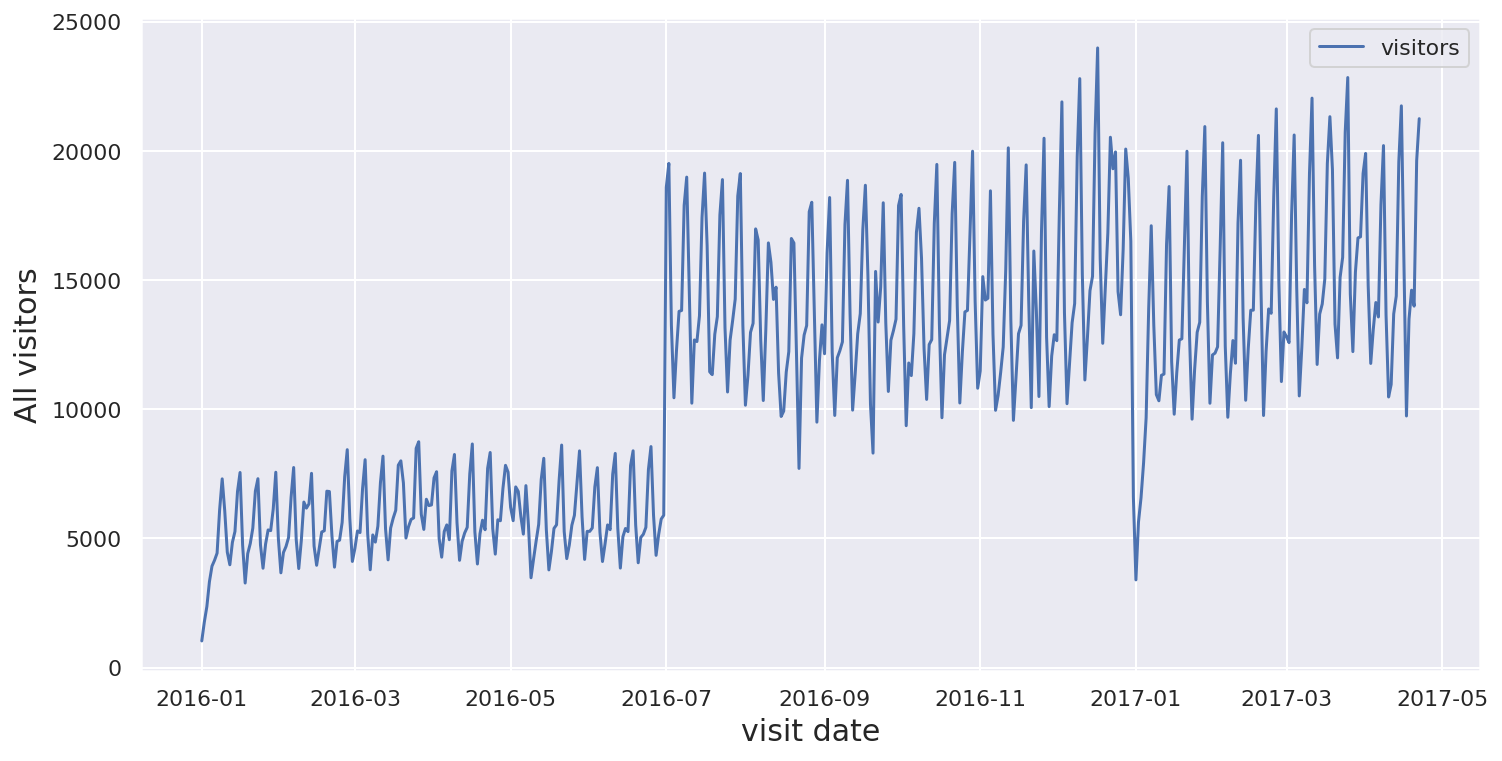

In [22]:
visitors_by_date = air_visits.groupby(['visit_date']).agg({'visitors': np.sum})
fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

- 2016년 7월에 총 방문객 수의 큰폭의 상승
- 2017년 1월에 큰 하락폭 존재
- 총 방문객 수의 패턴이 존재(일정 간격으로 패턴 반복)

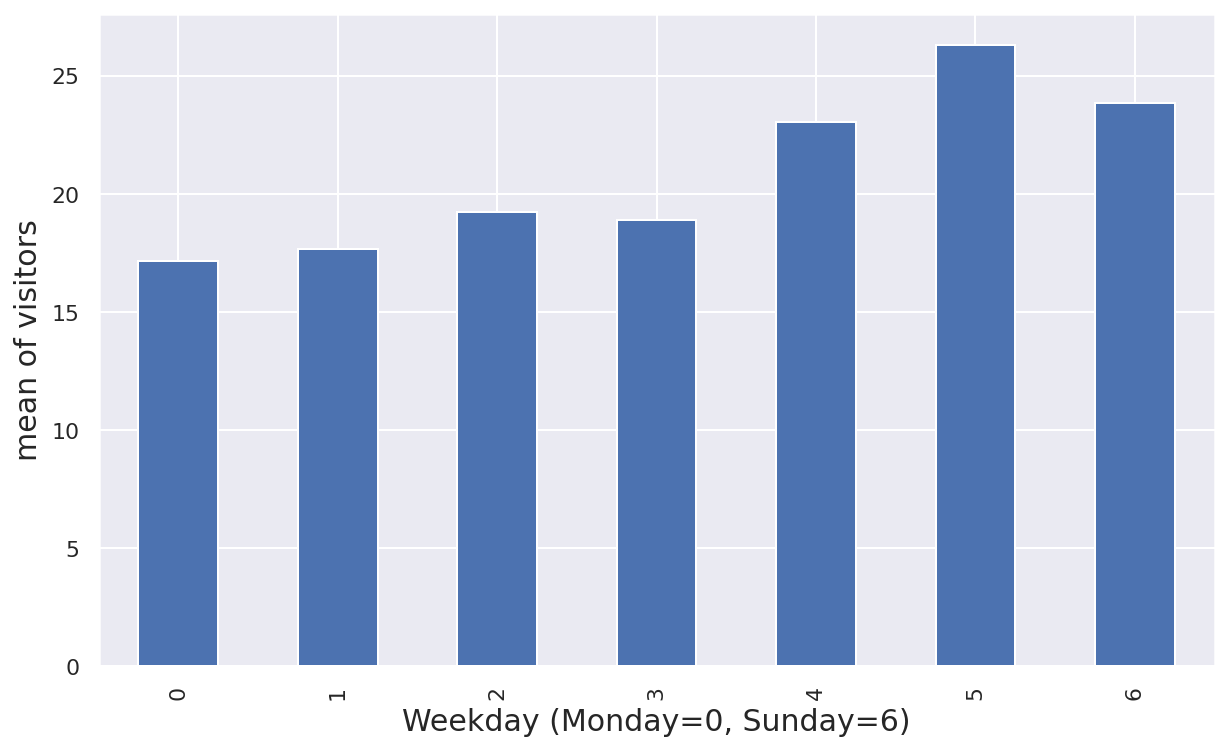

In [23]:
visitors_by_weekday = air_visits.groupby('dow')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Weekday (Monday=0, Sunday=6)',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

- 금,토, 일 평균 방문자 수가 다른 날들보다 많은 편

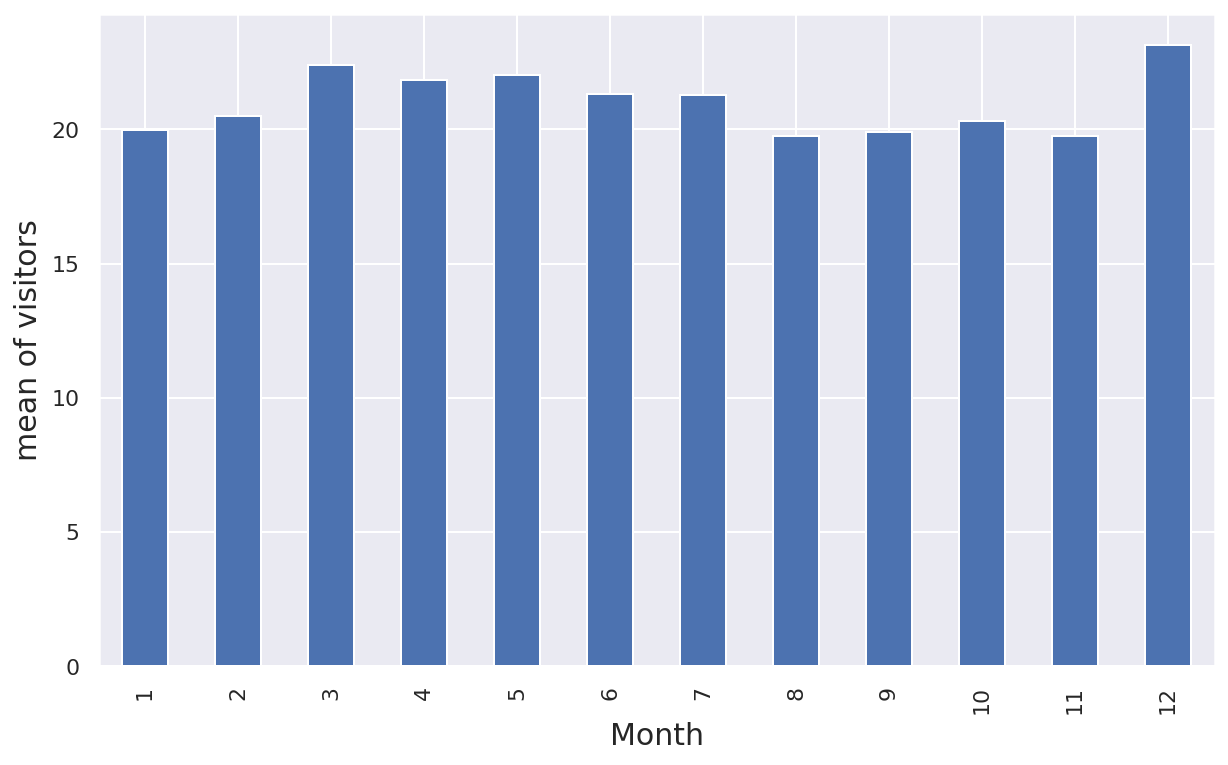

In [24]:
visitors_by_weekday = air_visits.groupby('month')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Month',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

월 기준 차트를 보면 12월이 가장 인기있는 달로 보이고, 3월~5월도 방문객수가 높은 편이다.

***

2017년 4월 마지막 주 ~ 5월까지의 예측을 위해 2016년 training data 보려는데 날짜가 6월 13일자 데이터만 뽑히는 중..8ㅅ8.

In [25]:
test_term_train = air_visits[air_visits["visit_date"].isin(pd.date_range('2016-04-15', '2017-06-15'))]
test_term_visitors = test_term_train.groupby('visit_date').agg({'visitors':np.sum})

In [26]:
air_visits[air_visits['visit_date'].isin(pd.date_range('2016-04-15', '2016-06-16'))]

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
91,air_ba937bf13d40fb24,2016-05-02,34,2,0,2016,5,18,2,2016-5
1070,air_35512c42db0868da,2016-05-02,14,2,0,2016,5,18,2,2016-5
2204,air_64d4491ad8cdb1c6,2016-05-02,14,2,0,2016,5,18,2,2016-5
4241,air_9438d67241c81314,2016-05-02,46,2,0,2016,5,18,2,2016-5
6111,air_d0e8a085d8dc83aa,2016-05-02,22,2,0,2016,5,18,2,2016-5
...,...,...,...,...,...,...,...,...,...,...
248516,air_bfafaed35e213fd7,2016-05-02,10,2,0,2016,5,18,2,2016-5
249167,air_e9ebf7fc520ac76a,2016-05-02,55,2,0,2016,5,18,2,2016-5
249578,air_7bc6ca04d7b0f3b8,2016-05-02,20,2,0,2016,5,18,2,2016-5
251210,air_0f2f96335f274801,2016-05-02,8,2,0,2016,5,18,2,2016-5


***

다음에 다시해보기 -> 그려보려고 한건 train, test의 년-월 기준으로 레코드 수, 

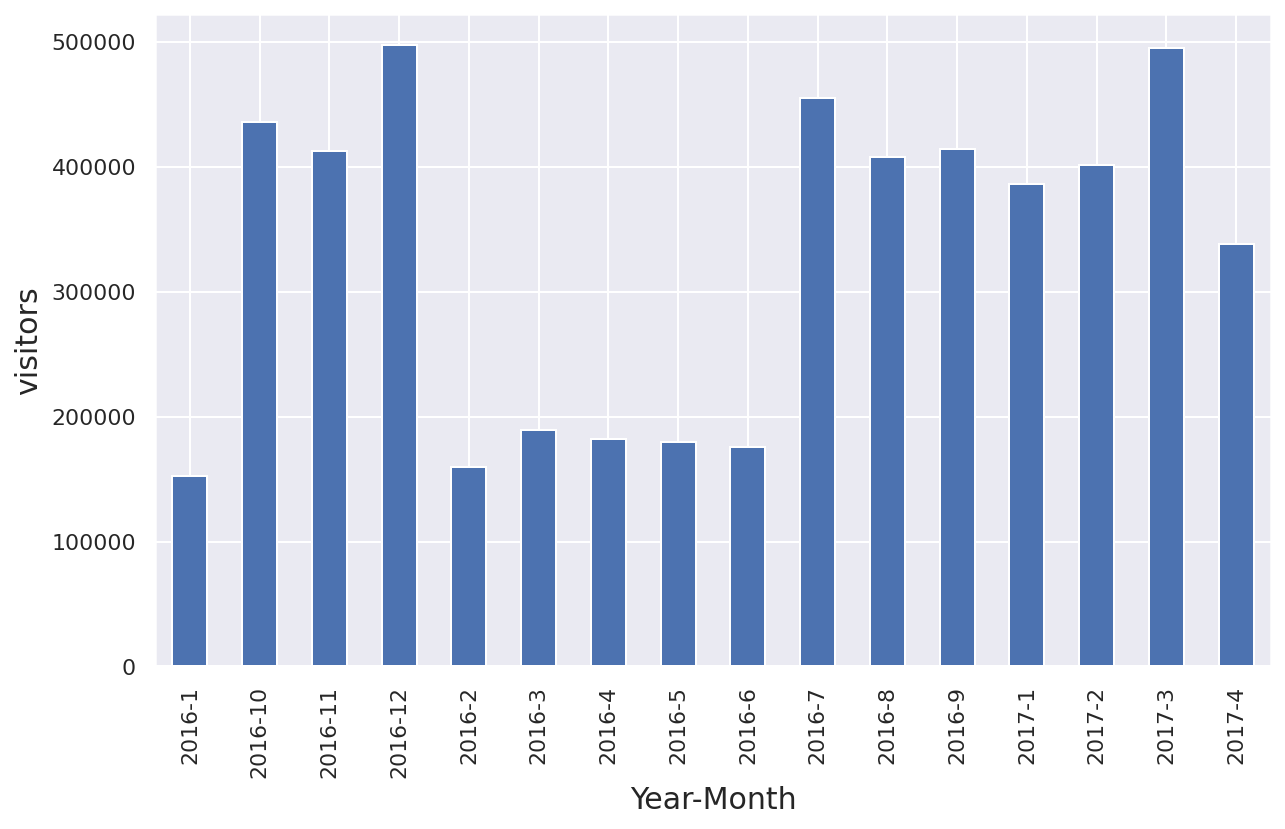

In [27]:
visitors_by_weekday = air_visits.groupby('year_mth')['visitors'].sum()
fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Year-Month',fontsize=15)
plt.ylabel('visitors',fontsize=15)
plt.show()

***

#### 식당 별 평균 방문자 수

In [28]:
air_visits.air_store_id.nunique()

829

In [29]:
air_visits.groupby('air_store_id').agg({'visitors':np.mean}).describe()

,visitors
count,829.000000
mean,21.203887
std,11.774992
min,1.187500
25%,11.812010
50%,19.183406
75%,28.645161
max,115.470588


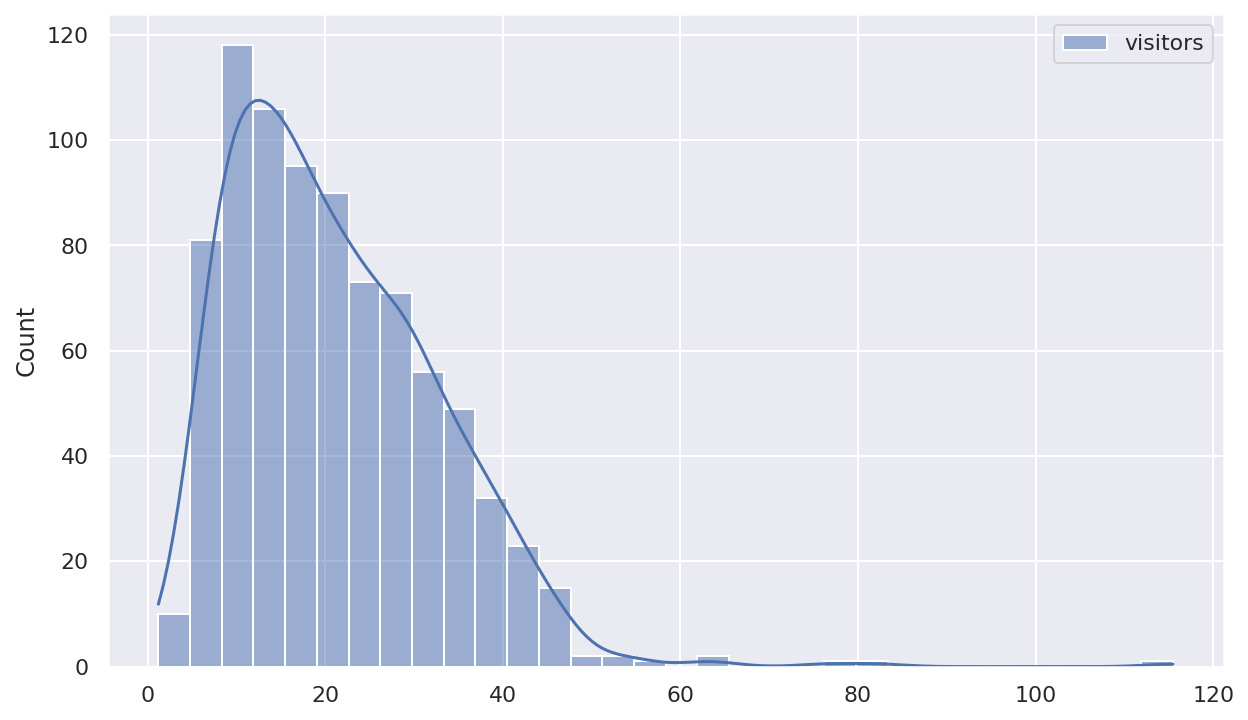

In [30]:
mean_visitor_by_res = air_visits.groupby('air_store_id').agg({'visitors':np.mean})
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

#### 식당 별 평균 방문자의 상자 그림

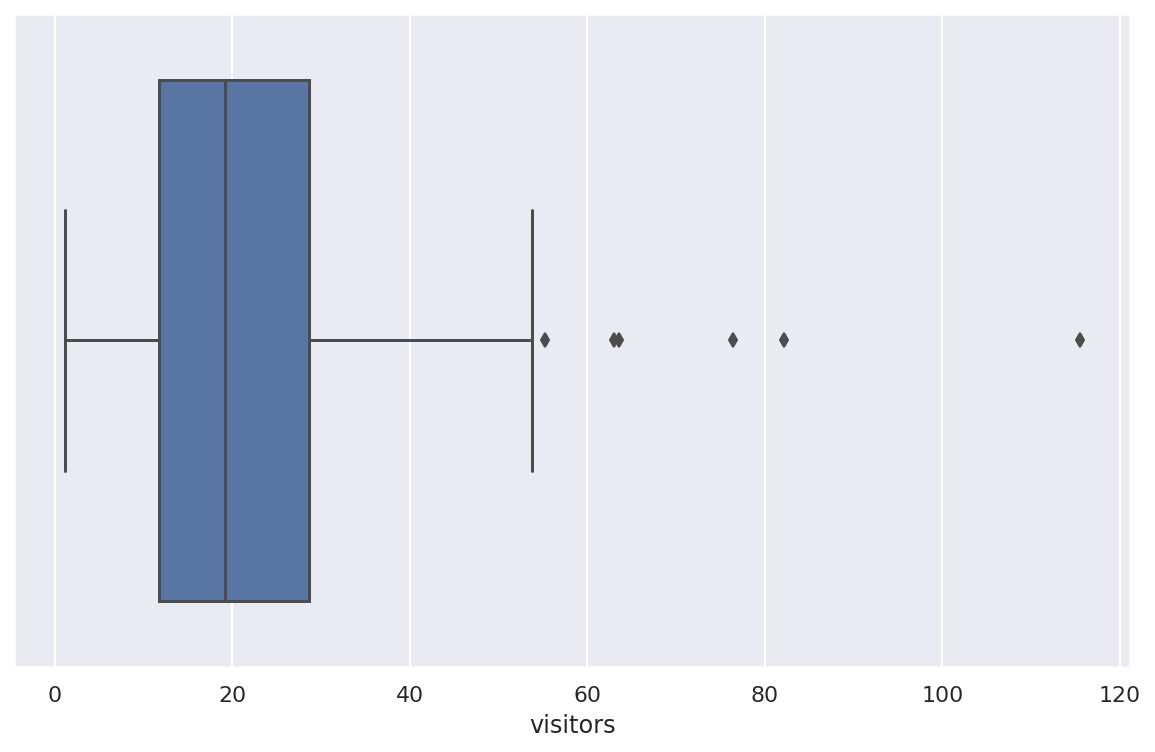

In [31]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_visitor_by_res['visitors'])
plt.show()

air_visit의 가게의 수:829개<br>
각 가게마다 평균 방문자 수를 보면 평균적으로 21명이 가게를 방문하며, 많게는 약 50~60명, 적게는 1명이다. 분포는 왼쪽으로 치우쳐 있는 형태를 가진다.



In [32]:
mean = pd.DataFrame(air_visits.groupby('air_store_id').agg({'visitors':np.mean}))
air_visits = pd.merge(air_visits, mean, how='left', on='air_store_id')
air_visits = air_visits.rename(columns={"visitors_x": "visitors", "visitors_y": "mean_visitors"}) # 컬럼명 mean_visitors로 변경

In [33]:
air_visits[air_visits['mean_visitors']> 54].air_store_id.unique()

array(['air_1c0b150f9e696a5f', 'air_df554c4527a1cfe6',
       'air_9c6787aa03a45586', 'air_258dc112912fc458',
       'air_789103bf53b8096b', 'air_900d755ebd2f7bbd'], dtype=object)

IQR 범위를 벗어난 이상치는 총 6개의 가게에서 확인할 수 있다.
- 'air_1c0b150f9e696a5f'
- 'air_df554c4527a1cfe6'
- 'air_9c6787aa03a45586'
- 'air_258dc112912fc458'
- 'air_789103bf53b8096b'
- 'air_900d755ebd2f7bbd'

In [34]:
air_visits[air_visits['air_store_id'] == 'air_1c0b150f9e696a5f']
air_visits[air_visits['air_store_id'] == 'air_df554c4527a1cfe6']
air_visits[air_visits['air_store_id'] == 'air_9c6787aa03a45586']
air_visits[air_visits['air_store_id'] == 'air_258dc112912fc458']
air_visits[air_visits['air_store_id'] == 'air_789103bf53b8096b']
air_visits[air_visits['air_store_id'] == 'air_900d755ebd2f7bbd']

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
158186,air_900d755ebd2f7bbd,2017-03-02,4,2,3,2017,3,9,1,2017-3,82.2
158187,air_900d755ebd2f7bbd,2017-04-01,47,1,5,2017,4,13,2,2017-4,82.2
158188,air_900d755ebd2f7bbd,2017-04-02,54,2,6,2017,4,13,2,2017-4,82.2
158189,air_900d755ebd2f7bbd,2017-04-04,79,4,1,2017,4,14,2,2017-4,82.2
158190,air_900d755ebd2f7bbd,2017-04-05,82,5,2,2017,4,14,2,2017-4,82.2
158191,air_900d755ebd2f7bbd,2017-04-06,89,6,3,2017,4,14,2,2017-4,82.2
158192,air_900d755ebd2f7bbd,2017-04-07,84,7,4,2017,4,14,2,2017-4,82.2
158193,air_900d755ebd2f7bbd,2017-04-08,67,8,5,2017,4,14,2,2017-4,82.2
158194,air_900d755ebd2f7bbd,2017-04-09,50,9,6,2017,4,14,2,2017-4,82.2
158195,air_900d755ebd2f7bbd,2017-04-11,75,11,1,2017,4,15,2,2017-4,82.2


주말에 급격한 방문자 수의 증가가 평균에 영향을 미쳤다. 아직은 이 부분이 모델에 미칠 영향을 파악하기 어려우니 일단 보류..

hpg_reservation 데이터랑 연계해서 특별한게 있는지 보기

### 4.2 Hpg reserve

In [35]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [36]:
print('Total hpg reserve visitors - ',hpg_reserve['reserve_visitors'].sum())

Total hpg reserve visitors -  10149193


#### 레스토랑 별 평균 예약 방문자 수

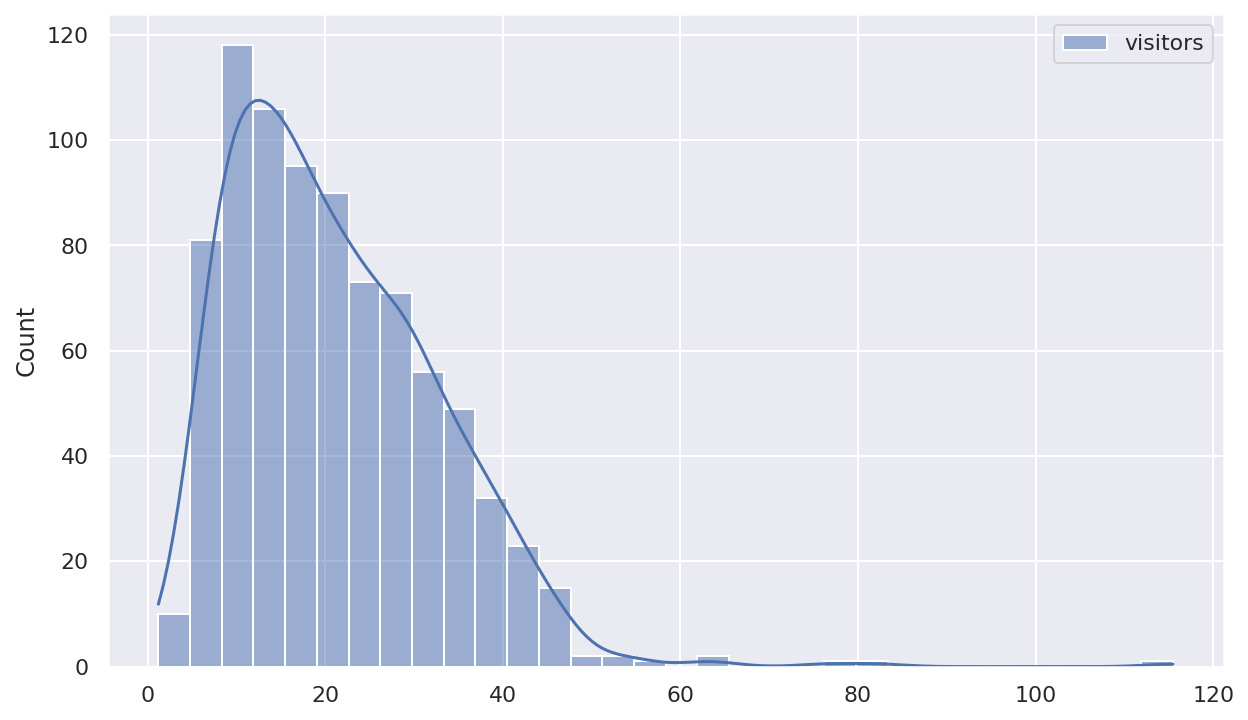

In [37]:
mean_reserve_byres = hpg_reserve.groupby('hpg_store_id').agg({'reserve_visitors':np.mean})
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

In [38]:
mean_reserve_byres.describe()

,reserve_visitors
count,13325.000000
mean,5.990761
std,3.955656
min,1.192857
25%,3.967742
50%,5.125000
75%,6.915493
max,84.000000


#### 레스토랑 당 평균 예약 방문자  상자 그림

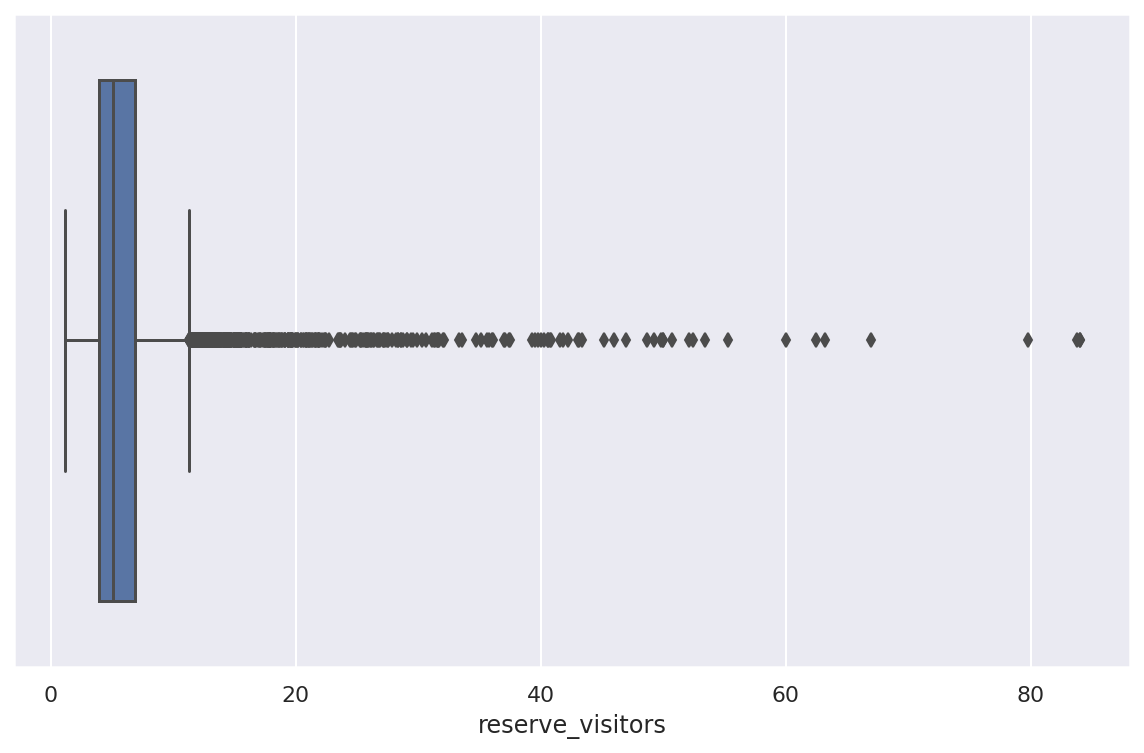

In [39]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_reserve_byres['reserve_visitors'])
plt.show()

레스토랑 별 평균 예약 방문자 수는 5명 정도이며, 예약 방문자 수가 5~12명 사이인 예약 수가 많다.
IQR범위인11.34명 이상인 예약이 575건이 있다. (전체 13325)

In [41]:
hpg_reserve = pd.merge(hpg_reserve, mean_reserve_byres, how='left', on='hpg_store_id')
hpg_reserve = hpg_reserve.rename(columns={"reserve_visitors_x": "reserve_visitors", "reserve_visitors_y": "mean_reserve_visitors"})

In [42]:
hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()
print(len(hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()))

575


#### 방문 시각

In [43]:
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_hour'] = hpg_reserve['visit_datetime'].dt.hour

In [44]:
time_reserve = hpg_reserve.groupby('visit_hour').agg({'reserve_visitors':np.sum})

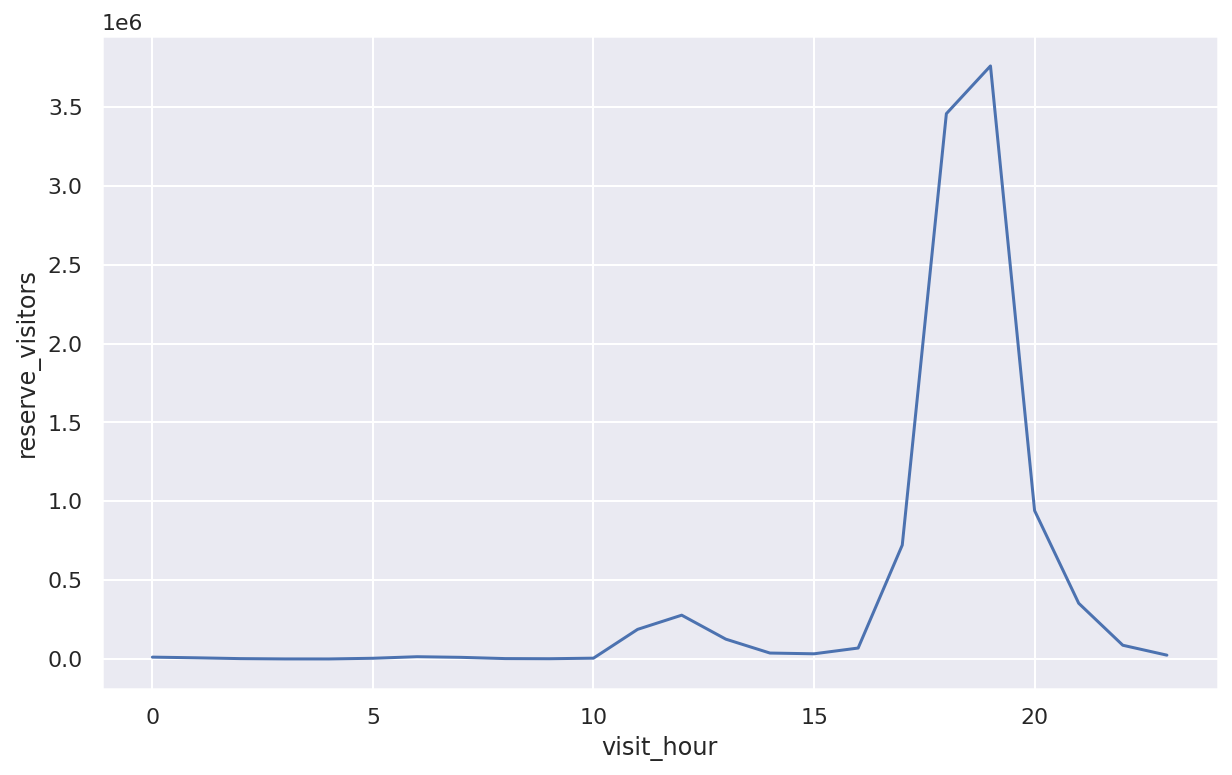

In [45]:
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='visit_hour', y='reserve_visitors', data=time_reserve)
plt.show()

저녁시간 예약이 많다

### 4.3 Hpg store

#### 장르별 레스토랑 시장 점유율

In [47]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [142]:
res_by_genre = pd.DataFrame(hpg_store.groupby(['hpg_genre_name'])['hpg_store_id'].value_counts()).groupby('hpg_genre_name').agg({'hpg_store_id':np.sum})
res_by_genre.sort_values(by='hpg_store_id', ascending=False)

,hpg_store_id
hpg_genre_name,
Japanese style,1750
International cuisine,700
Creation,410
Seafood,339
Grilled meat,325
Italian,249
Spain Bar/Italian Bar,229
Chinese general,91
Japanese food in general,85


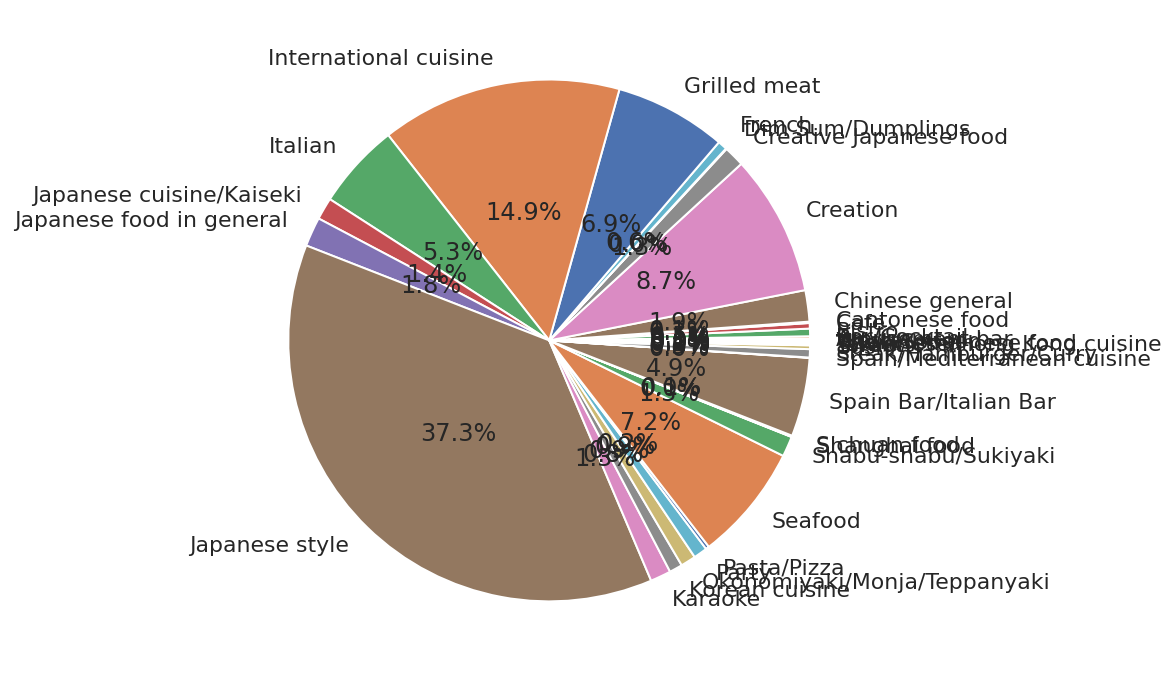

In [139]:
from matplotlib import pyplot as plt
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(res_by_genre['hpg_store_id'], labels=res_by_genre['hpg_store_id'].keys(), autopct='%0.1f%%',pctdistance=0.5)
plt.show()

hpg의 레스토랑은 34개의 장르로 세분화.
Japanese style이 37.3%로 가장 많은 비중을 차지하고 International cusine 14.9%로 두 장르의 레스토랑이 전체의 50정도를 차지한다.

#### 장르별 예약자 수

In [71]:
hpg_full = pd.merge(hpg_reserve, hpg_store, how='left', on='hpg_store_id')
hpg_full.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,mean_reserve_visitors,visit_hour,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,4.947761,11,NaN,NaN,NaN,NaN
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2.381967,13,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,4.904040,16,NaN,NaN,NaN,NaN
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,8.312500,17,NaN,NaN,NaN,NaN
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,3.873950,17,NaN,NaN,NaN,NaN


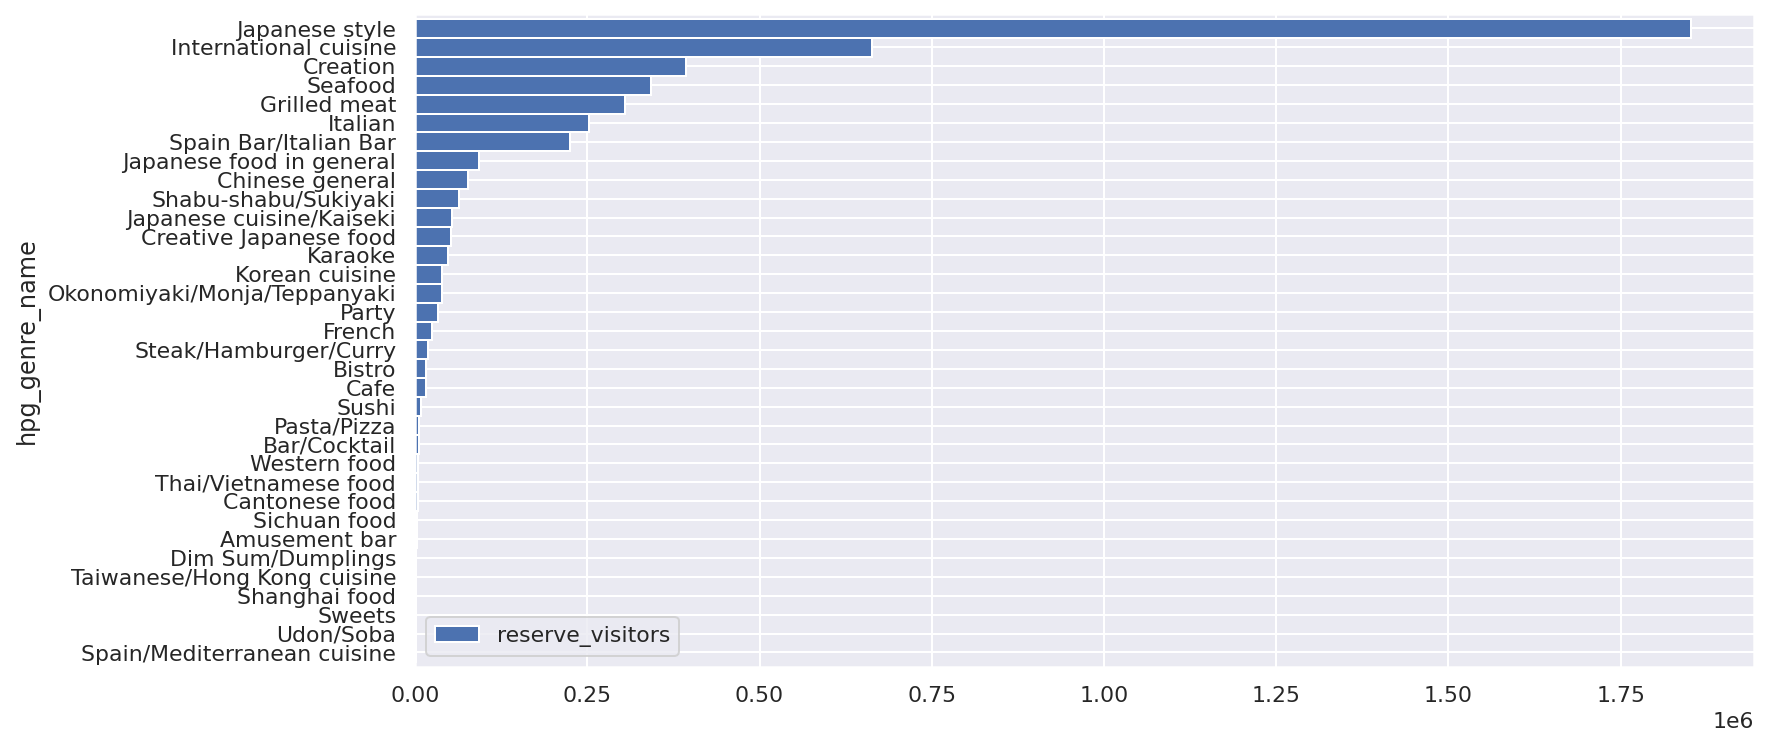

In [98]:
visitor_by_genre = hpg_full.groupby('hpg_genre_name').agg({'reserve_visitors':np.sum})
fig,ax = plt.subplots(figsize=(12,6))
visitor_by_genre.sort_values(by='reserve_visitors', ascending=True).plot(kind='barh', width=1,ax=ax)
plt.show()

레스토랑의 비중으로 본 인기 장르와 마찬가지로, 예약 방문객의 수도 japanase style, international cusine, creation, seafood, grilled meat 순으로 인기가 많다.

## Ref

https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r

https://ichi.pro/ko/leseutolang-bangmunja-yecheug-mojib-274807169618035